In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
## Read raw data
df = pd.read_csv("digital.csv")

data = df.to_numpy()

In [3]:
## Convert data into bytes
bytes = np.zeros(shape=(df.shape[0], 2), dtype=np.uint8)

kMaxBits = int(8)
kClockTime = 0.000002
kTol = 0.0000002

bit_count = int(0)
mosi_byte = int(0)
miso_byte = int(0)

kTimeBitIdx = 0
kMisoBitIdx = 1
kMosiBitIdx = 2
kSckBitIdx = 3

kMisoByteIdx = 0
kMosiByteIdx = 1

byte_idx = 0

print("Decoding...")

bad_sck = 0
bad_sck_time = []
curr_time = 0
prev_time = 0

curr_byte_time = 0
byte_time = []

for i in range(1, data.shape[0]):
    # Hack to avoid a patch of bad clock cycles that messup the counting (；￣Д￣）
    if data[i][kTimeBitIdx] > 409.379394400 and data[i][kTimeBitIdx] < 409.866634400:
        continue
    
    if((data[i-1][kSckBitIdx] == 0) and (data[i][kSckBitIdx] == 1)):
        curr_time = data[i][kTimeBitIdx]
        dt = (curr_time-prev_time)
        prev_time = curr_time

        shift = (kMaxBits - 1) - bit_count

        # Assume the first bit is good
        if (bit_count == 0):
            curr_byte_time = curr_time
            miso_byte = miso_byte | (int(data[i][kMisoBitIdx]) << shift)
            mosi_byte = mosi_byte | (int(data[i][kMosiBitIdx]) << shift)
            bit_count += 1
        # If clock rate is ok, store the bit
        elif (abs(dt - kClockTime) < kTol):
            miso_byte = miso_byte | (int(data[i][kMisoBitIdx]) << shift)
            mosi_byte = mosi_byte | (int(data[i][kMosiBitIdx]) << shift)
            bit_count += 1
        # If clock rate is bad, reset the byte and store the latest bit in case it's a good bit
        else:
            bad_sck += 1
            bad_sck_time.append(curr_time)
            
            bit_count = 0
            mosi_byte = 0
            miso_byte = 0

            curr_byte_time = curr_time
            miso_byte = miso_byte | (int(data[i][kMisoBitIdx]) << shift)
            mosi_byte = mosi_byte | (int(data[i][kMosiBitIdx]) << shift)
            bit_count += 1

        # We have a full byte. Store and reset counters
        if (bit_count == 8):
            byte_time.append(curr_time)
            bytes[byte_idx][kMisoByteIdx] = miso_byte
            bytes[byte_idx][kMosiByteIdx] = mosi_byte
            byte_idx += 1
            bit_count = 0
            mosi_byte = 0
            miso_byte = 0
    if i % 1000000 == 0:
        print(f'{(i/data.shape[0])*100:.2f}', "%")

print("100.0 %")
print("\nBad edges: ", bad_sck)
    
kValuesEndIdx = byte_idx

Decoding...
7.19 %
14.38 %
21.58 %
28.77 %
35.96 %
43.15 %
50.35 %
57.54 %
64.73 %
71.92 %
79.12 %
86.31 %
93.50 %
100.0 %

Bad edges:  39


In [4]:
## Separate by transactions

transactions = []
transaction_time = []
kTransactionSizes = np.array([12, 4, 12, 12, 4, 12, 12, 12, 12, 12])

size_idx = 0
j = 0

while j < kValuesEndIdx:
    tran = np.zeros(kTransactionSizes[size_idx])

    for k in range(0, kTransactionSizes[size_idx]):
        tran[k] = bytes[j + k][kMisoByteIdx]

    transaction_time.append(byte_time[j])
    transactions.append(tran)

    j += kTransactionSizes[size_idx]
    
    if size_idx + 1 == kTransactionSizes.size:
        size_idx = 0
    else:
        size_idx += 1


In [5]:
## Get Cell Voltage Groups and their expected PEC value
counter = 0

data2pec = []
pec = []

for t in transactions:
    if (counter % 10 >= 5) and (counter % 10 <= 8):
        data2pec.append([t[4],t[5],t[6],t[7],t[8],t[9]])
        pec.append(((int(t[10]) << 8 ) | int(t[11])))
    
    counter += 1

In [6]:
## Generate PEC15 table
pec15table = np.zeros(256, dtype=np.int16)
crc15_poly = int(0x4599)

remainder = int(0)
r = int(0)

for idx in range(0, 256):
    remainder = r << 7
    r += 1

    for j in range(8, 0, -1):
        if (remainder & 0x4000):
            remainder = ((remainder << 1))
            remainder = (remainder ^ crc15_poly)
        else:
            remainder = ((remainder << 1))
    
    pec15table[idx] = np.array(remainder & 0xFFFF).astype(np.uint16)


In [7]:

## Calculate PEC
local_pec = []

for d in data2pec:
    remainder = np.uint16(0)
    remainder = 16 # PEC seed
    for i in range(0, len(d)):
        address = ((remainder >> 7) ^ np.uint16(d[i])) & 0xFF
        remainder = (remainder << 8) ^ pec15table[address]

    local_pec.append(np.array(remainder * 2).astype(np.uint16))

C:\Users\Marco.Nunez\AppData\Local\Temp\ipykernel_11812\1353448743.py:11: RuntimeWarning: overflow encountered in scalar multiply
  local_pec.append(np.array(remainder * 2).astype(np.uint16))


In [8]:
## Compare local to received PEC
pec_ok = []
num_success_pec = 0

for i in range(0, len(pec)):
    pec_ok.append((pec[i] == local_pec[i]))
    if(pec[i] == local_pec[i]):
        num_success_pec += 1

print("Total", num_success_pec, "successful PEC checks --", f'{(num_success_pec/len(pec)*100):.3f}', "%")


Total 3681 successful PEC checks -- 13.109 %


In [9]:
## Get all cell voltages
cell_v = np.zeros((int(len(data2pec)/4), 12))
cell_times = np.zeros((int(len(data2pec)/4)*12))

# get cell times
counter = 0
for i in range(0, len(transactions)):
    if (i % 10 == 4) or (i % 10 == 6) or (i % 10 == 8):
        cell_times[counter] = transaction_time[i]
        counter += 1
cell_times = np.reshape(cell_times, cell_v.shape)

# flip first bit
flip = False

point_count = 0
cell_count = 0
for d in data2pec:
    n = 0
    while n < len(d):
        cell_v[point_count][cell_count] = float( 
                (int(d[n+1]) << 8) | int(d[n]) 
            ) / 10000.0
        
        if flip and ((int(d[n+1]) << 8) | int(d[n])) > 42000:
            cell_v[point_count][cell_count] = float(((int(d[n+1]) << 8) | int(d[n])) & 0x7FFF) / 10000.0

        n += 2
        cell_count += 1
    
    if (cell_count == 12):
        cell_count = 0
        point_count += 1

In [10]:
## PEC checks...

cell_subset = cell_v[4000:4500,:]
pec_subset = pec[4000:4500]


<Axes: >

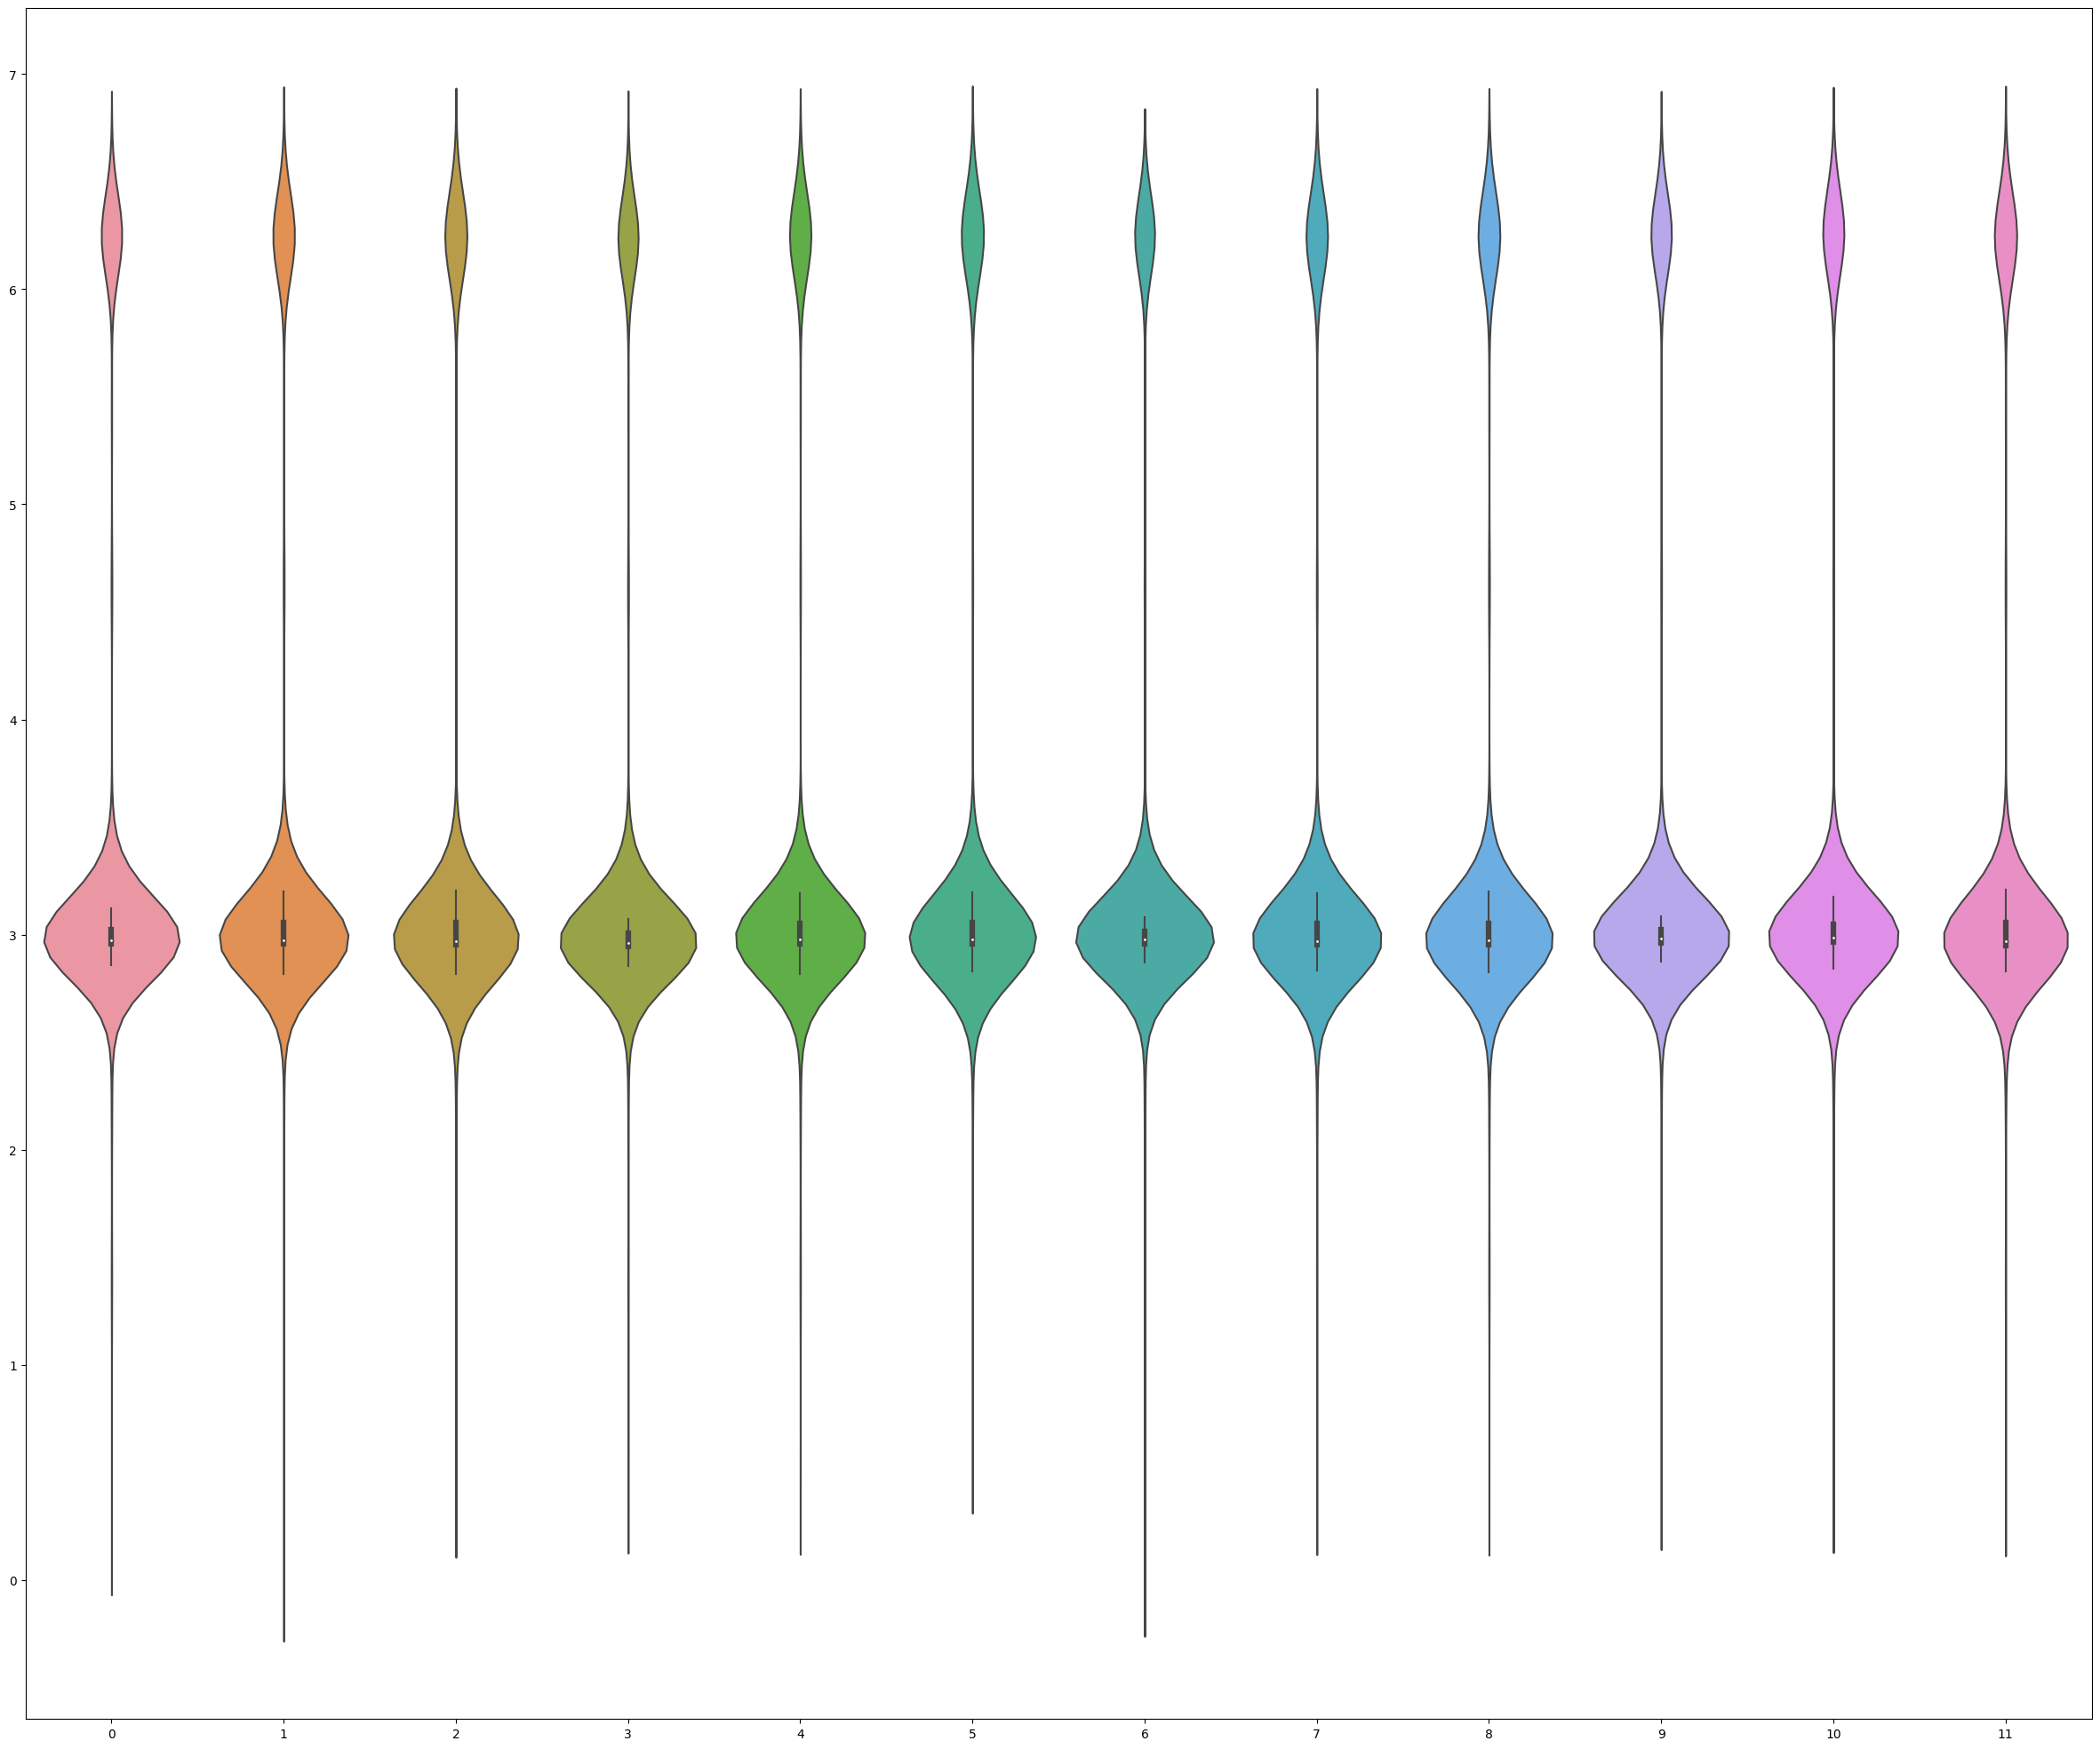

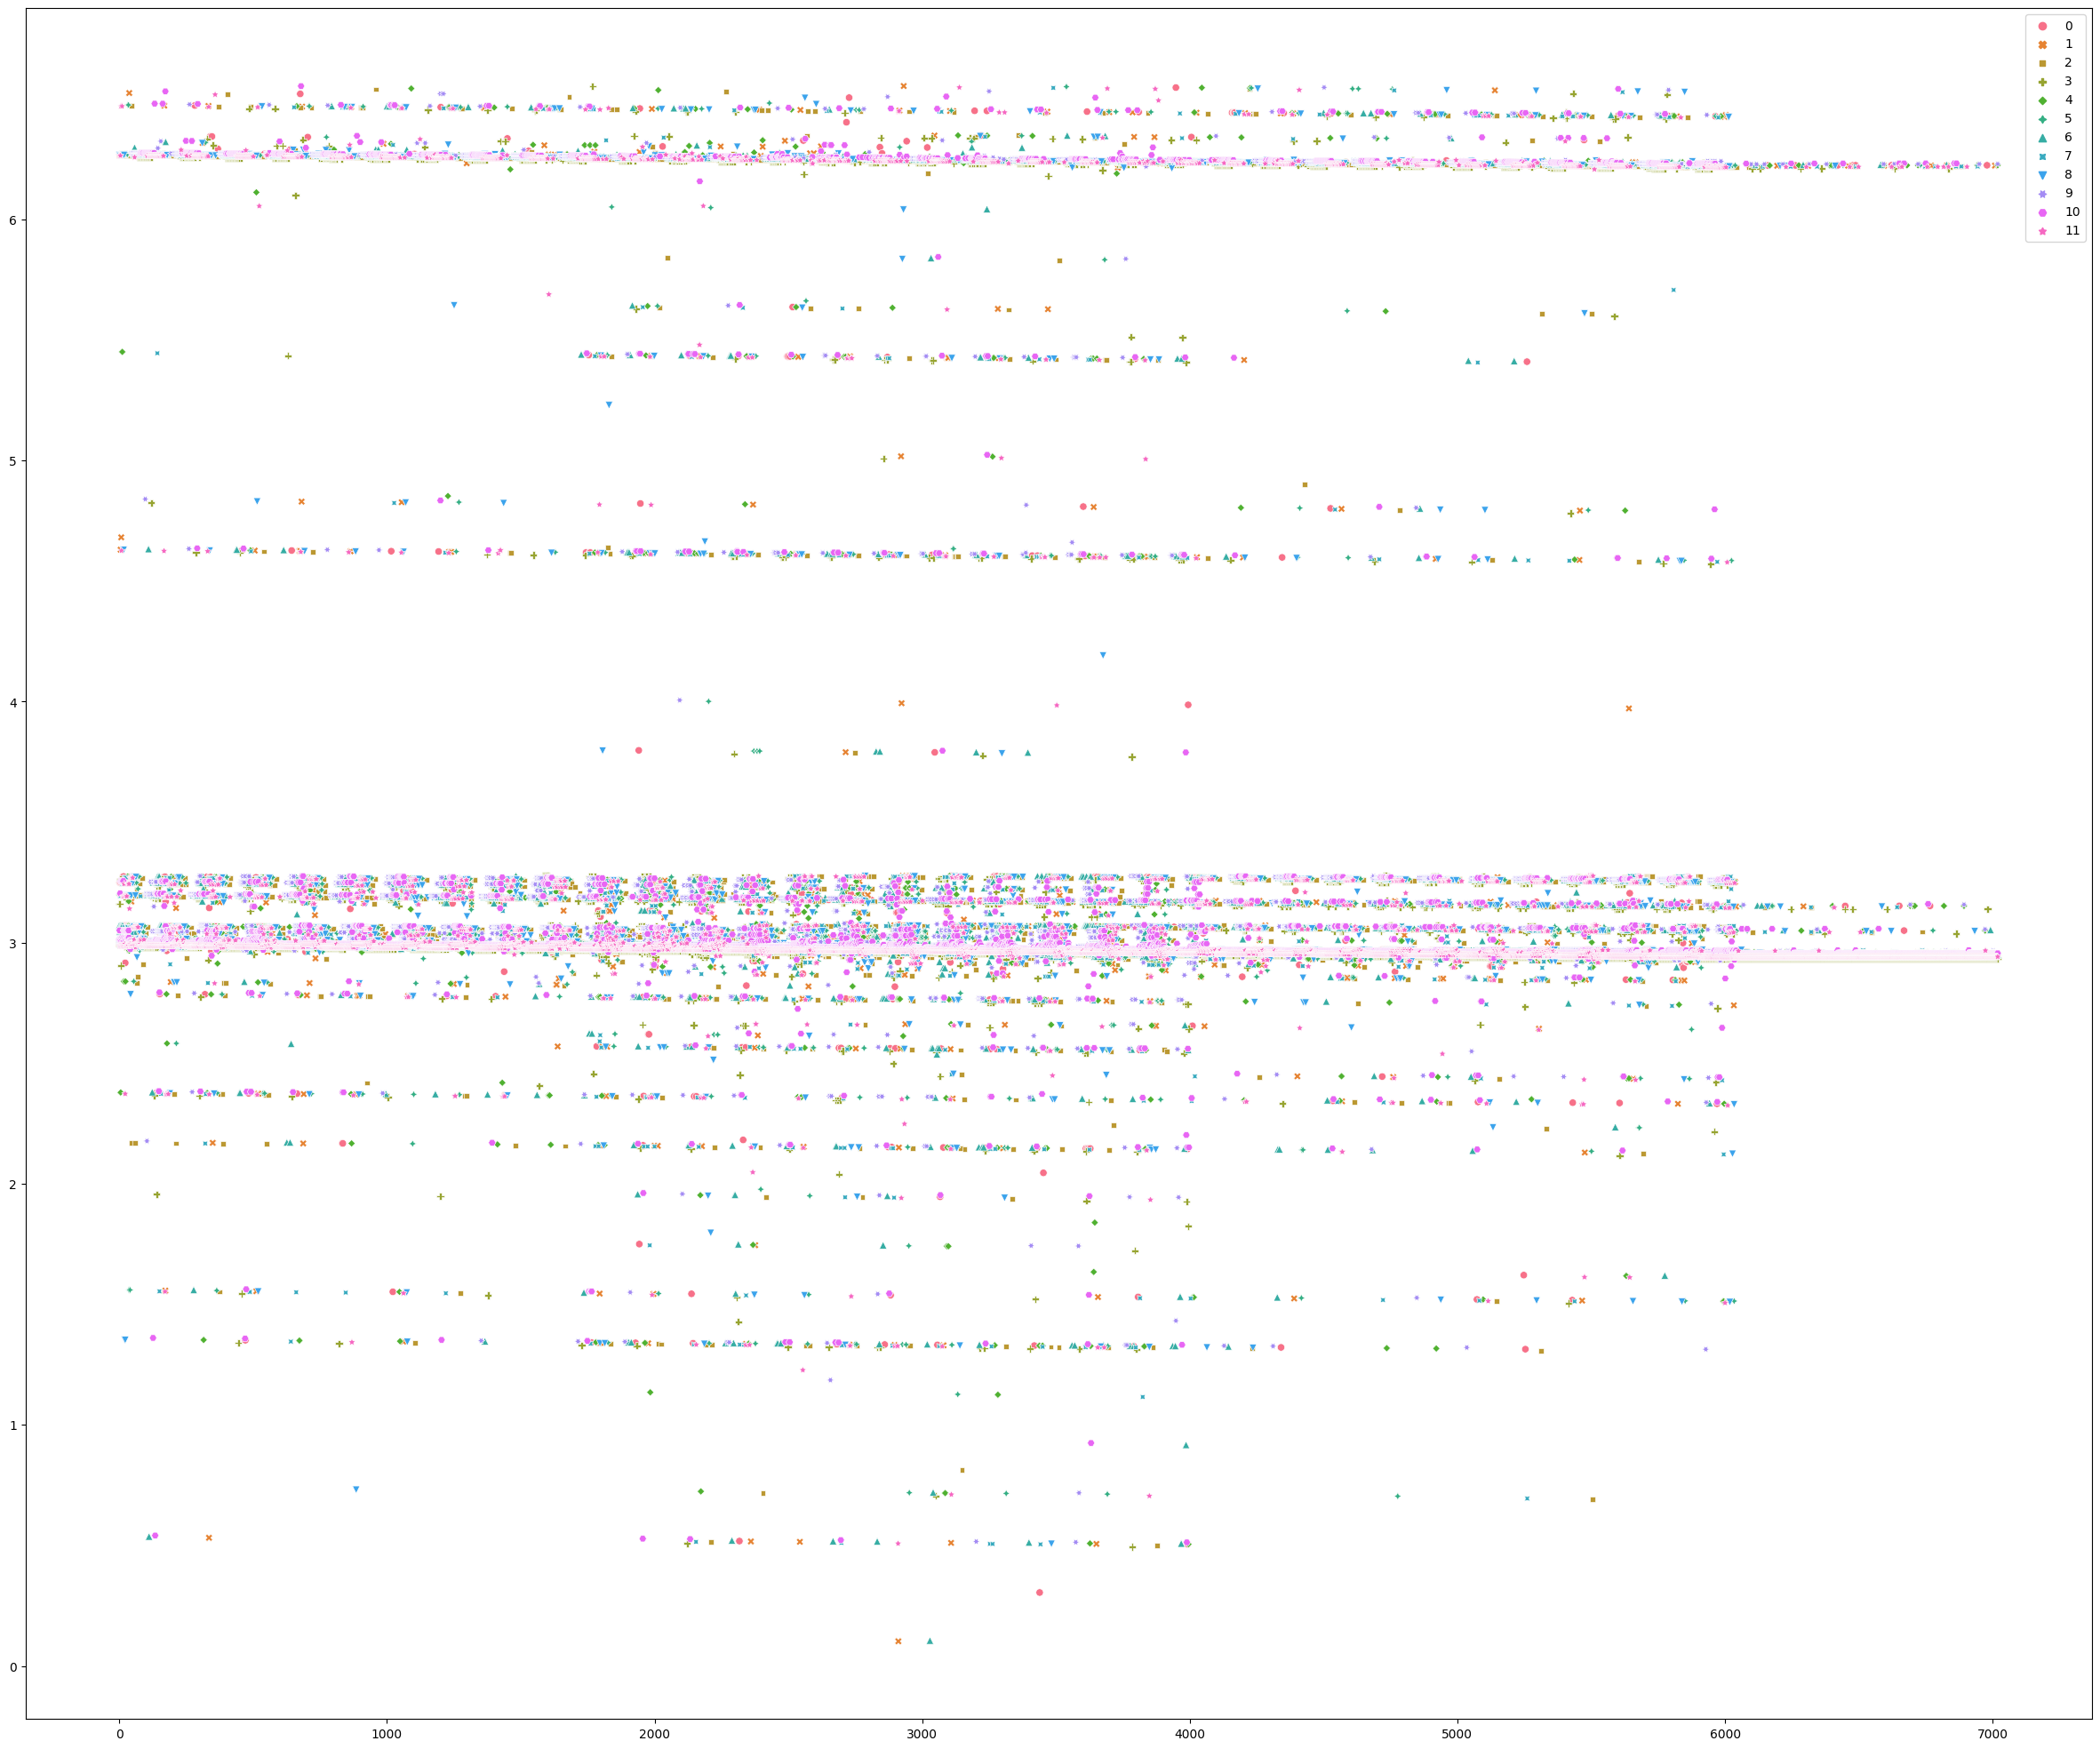

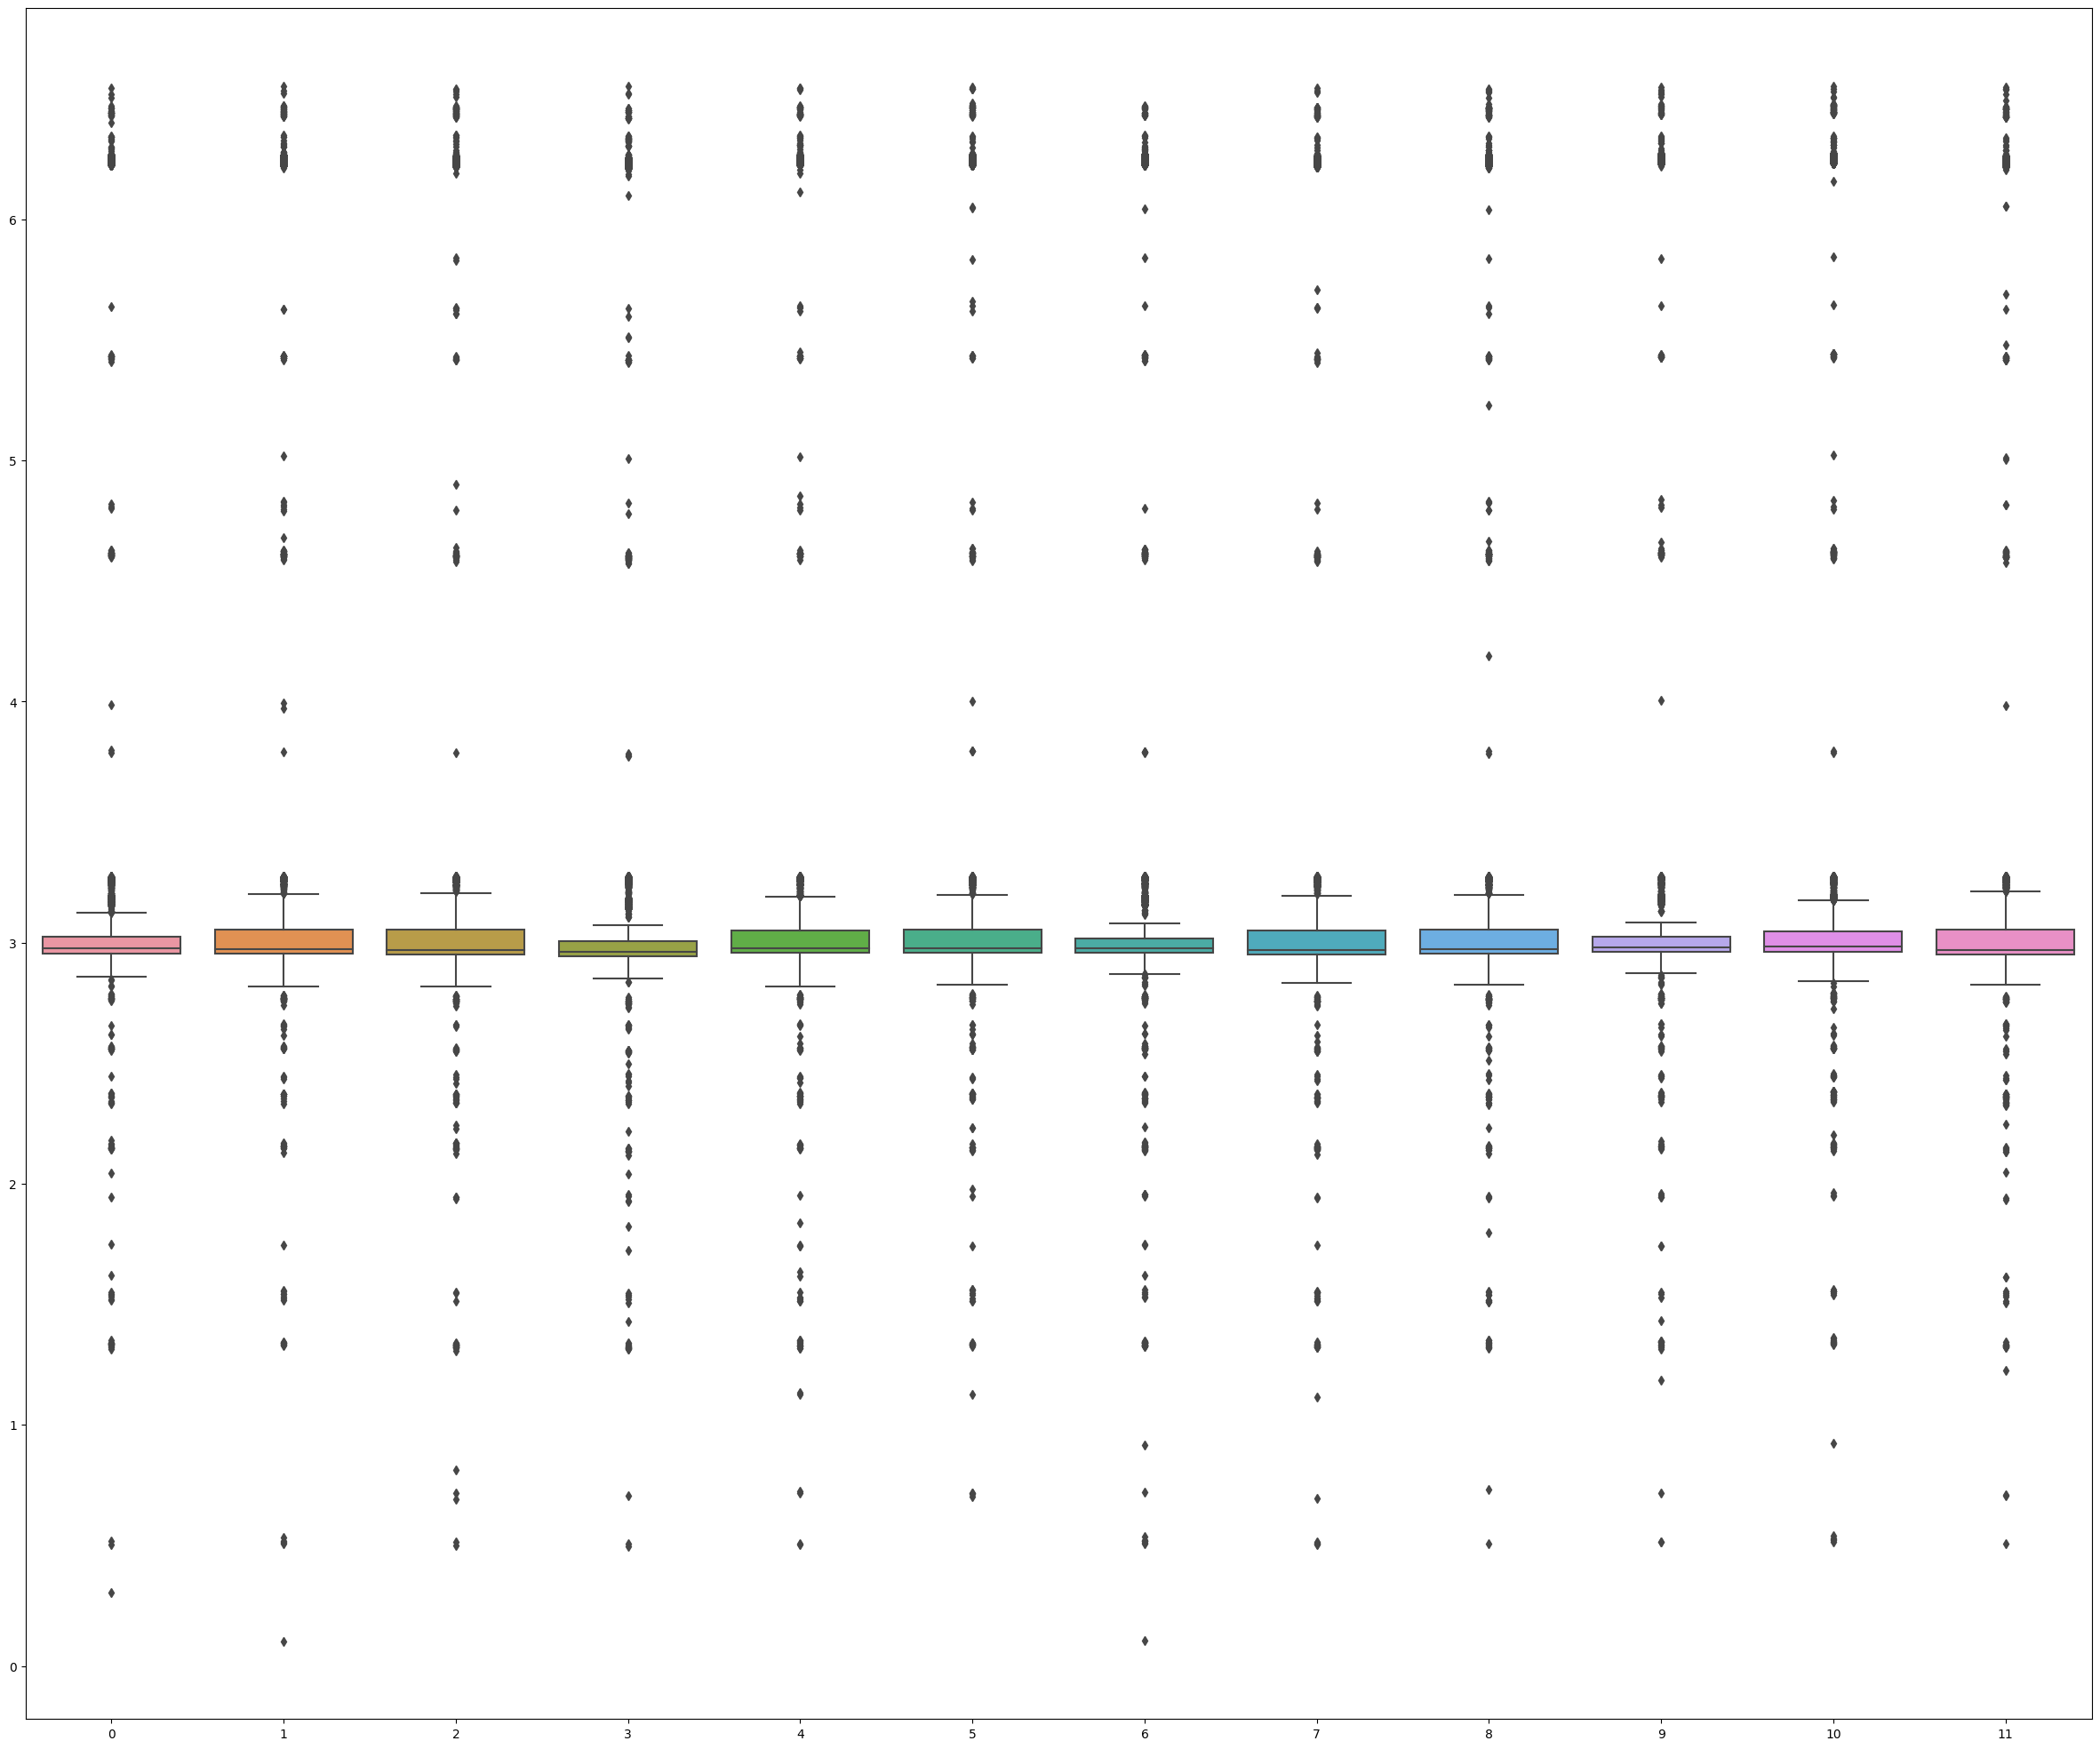

In [11]:
## Plot Cell Voltages
fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
sns.violinplot(cell_v)
fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
sns.scatterplot(cell_v)
fig, axs = plt.subplots(ncols=1, figsize=(30, 25))
sns.boxplot(cell_v)
# sns.clustermap(cell_v, row_cluster=False)


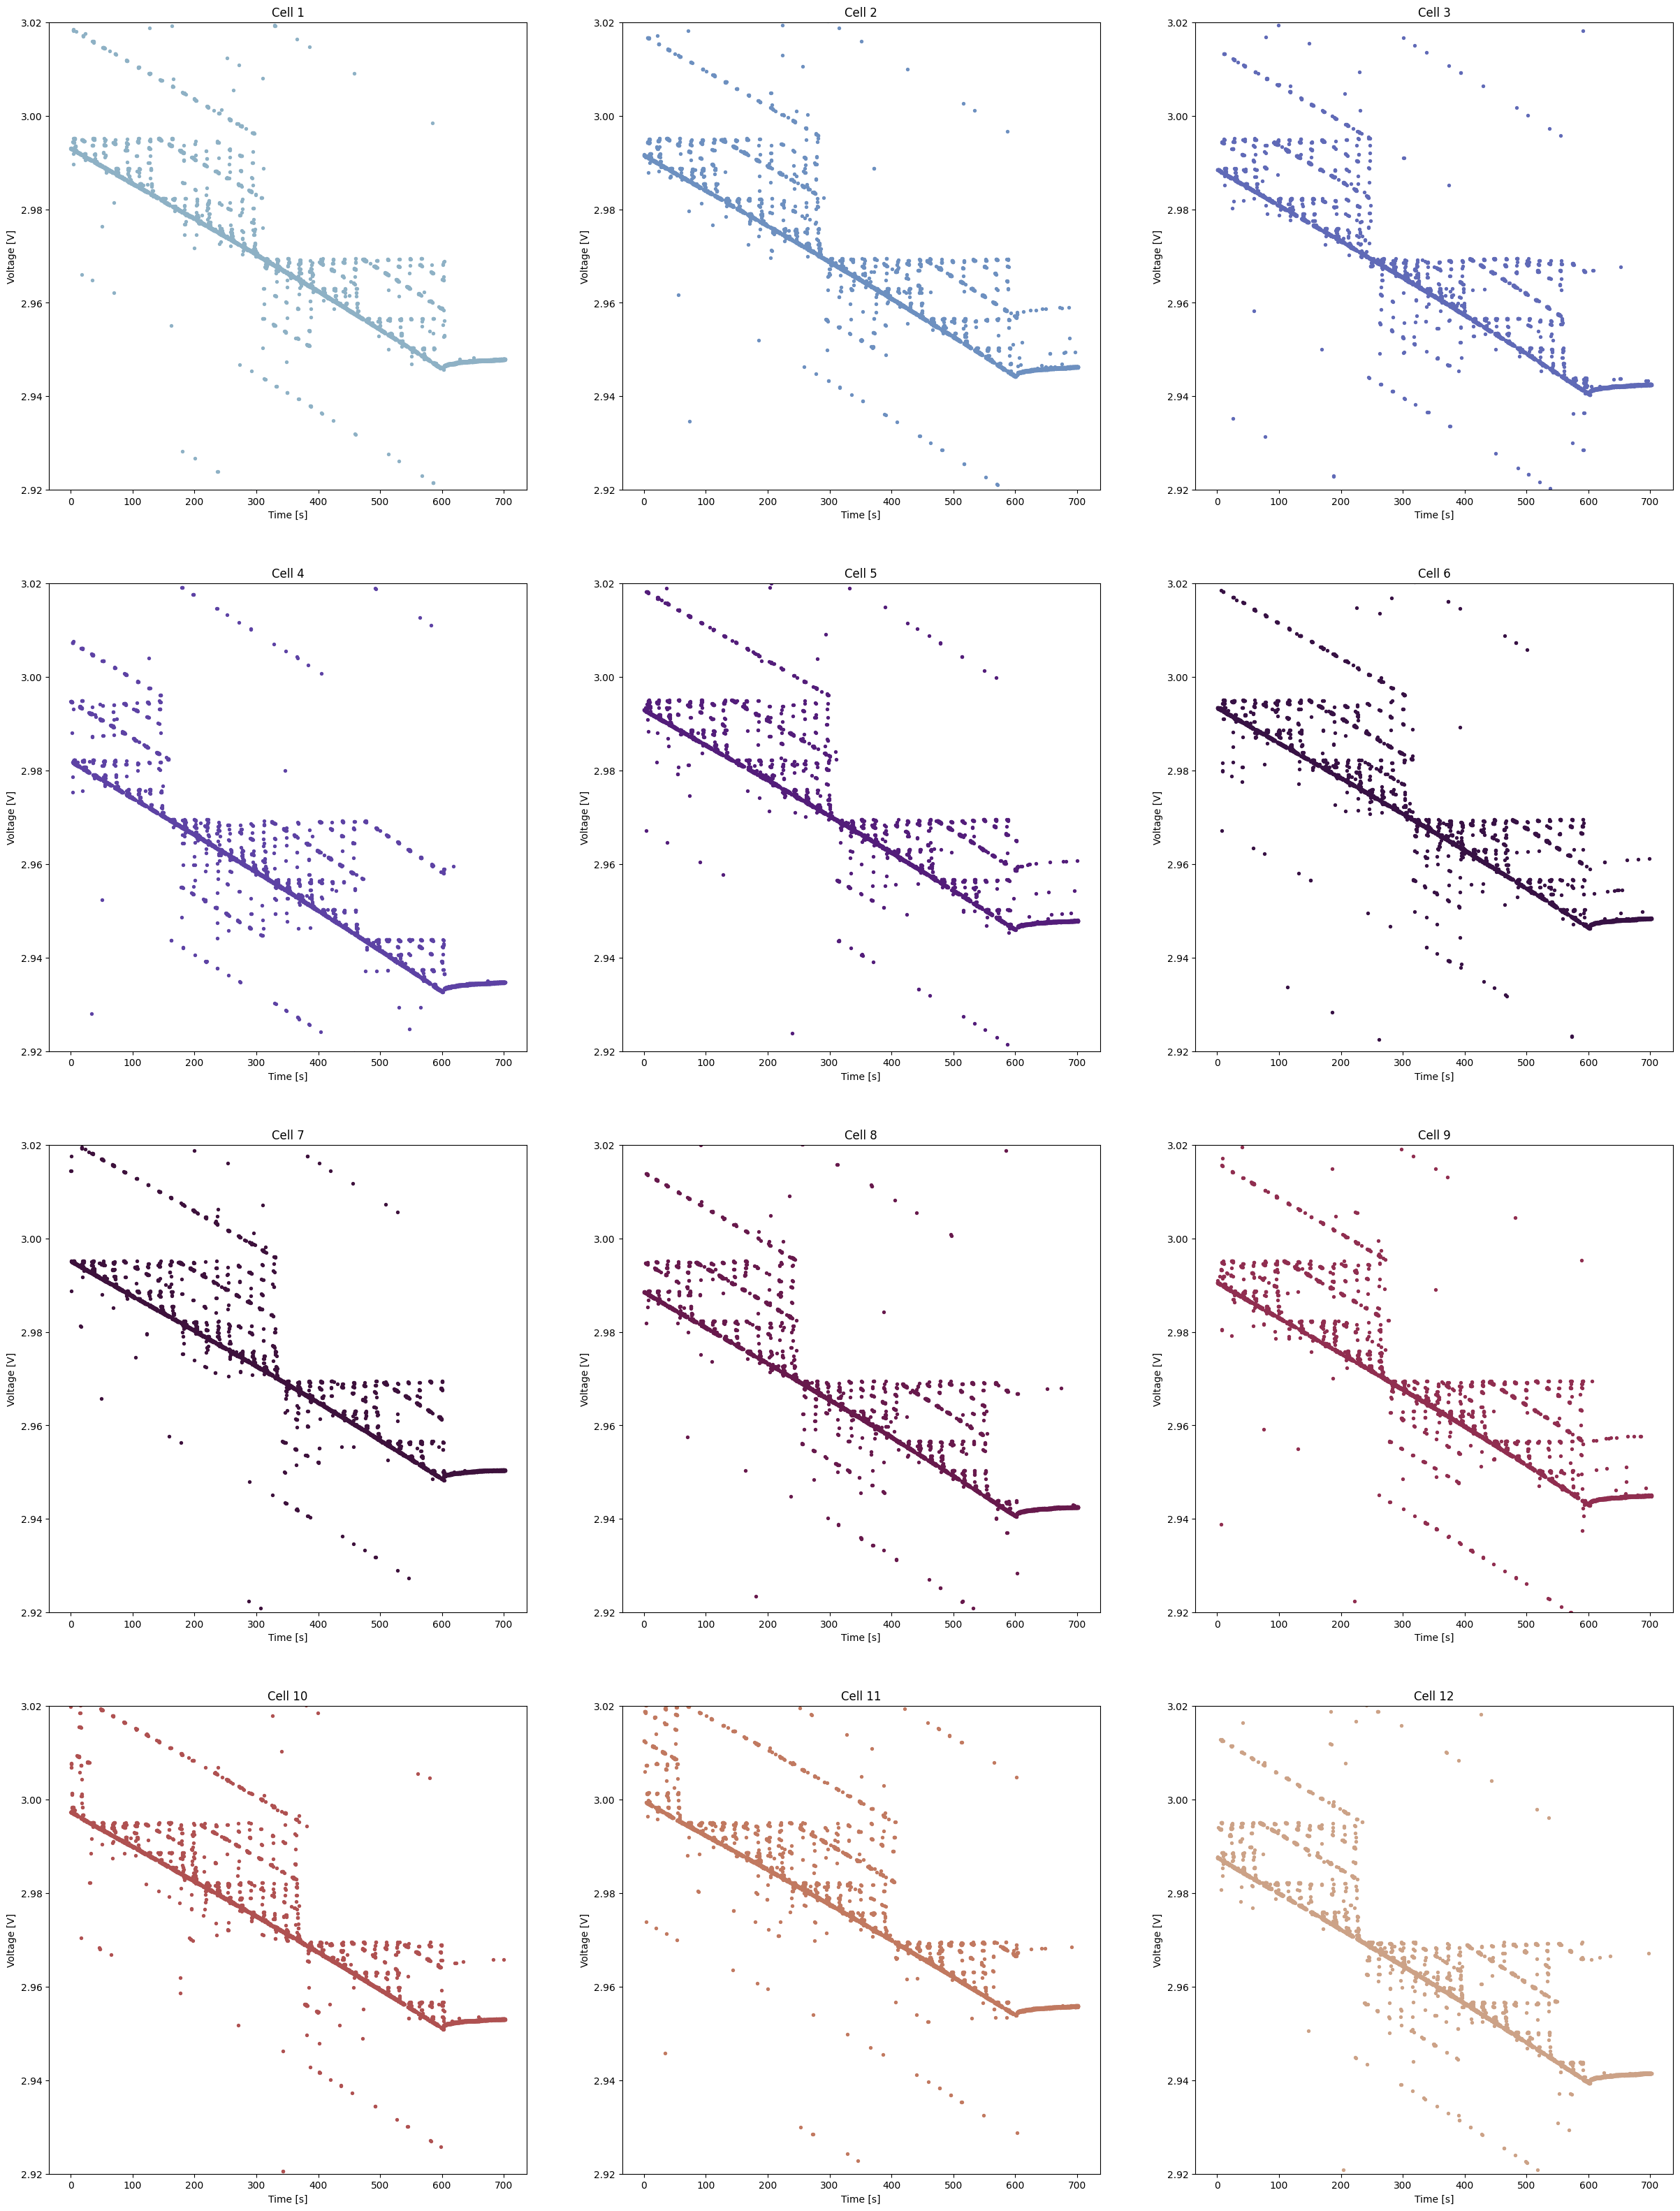

In [12]:
## Cell Voltages
t = np.arange(0, cell_v.shape[0], 1)/10

start = 1
end = 12
zoom = True

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))

for i in range(start-1, end):
    plot = axs[int(i/3),int(i%3)]
    plot.scatter(t, cell_v[:,i], s=8, color=c[i+2])
    if zoom:
        plot.set_ylim([2.92, 3.02])
    plot.set_xlabel("Time [s]")
    plot.set_ylabel("Voltage [V]")
    name = "Cell " + str(i+1)
    plot.set_title(name)


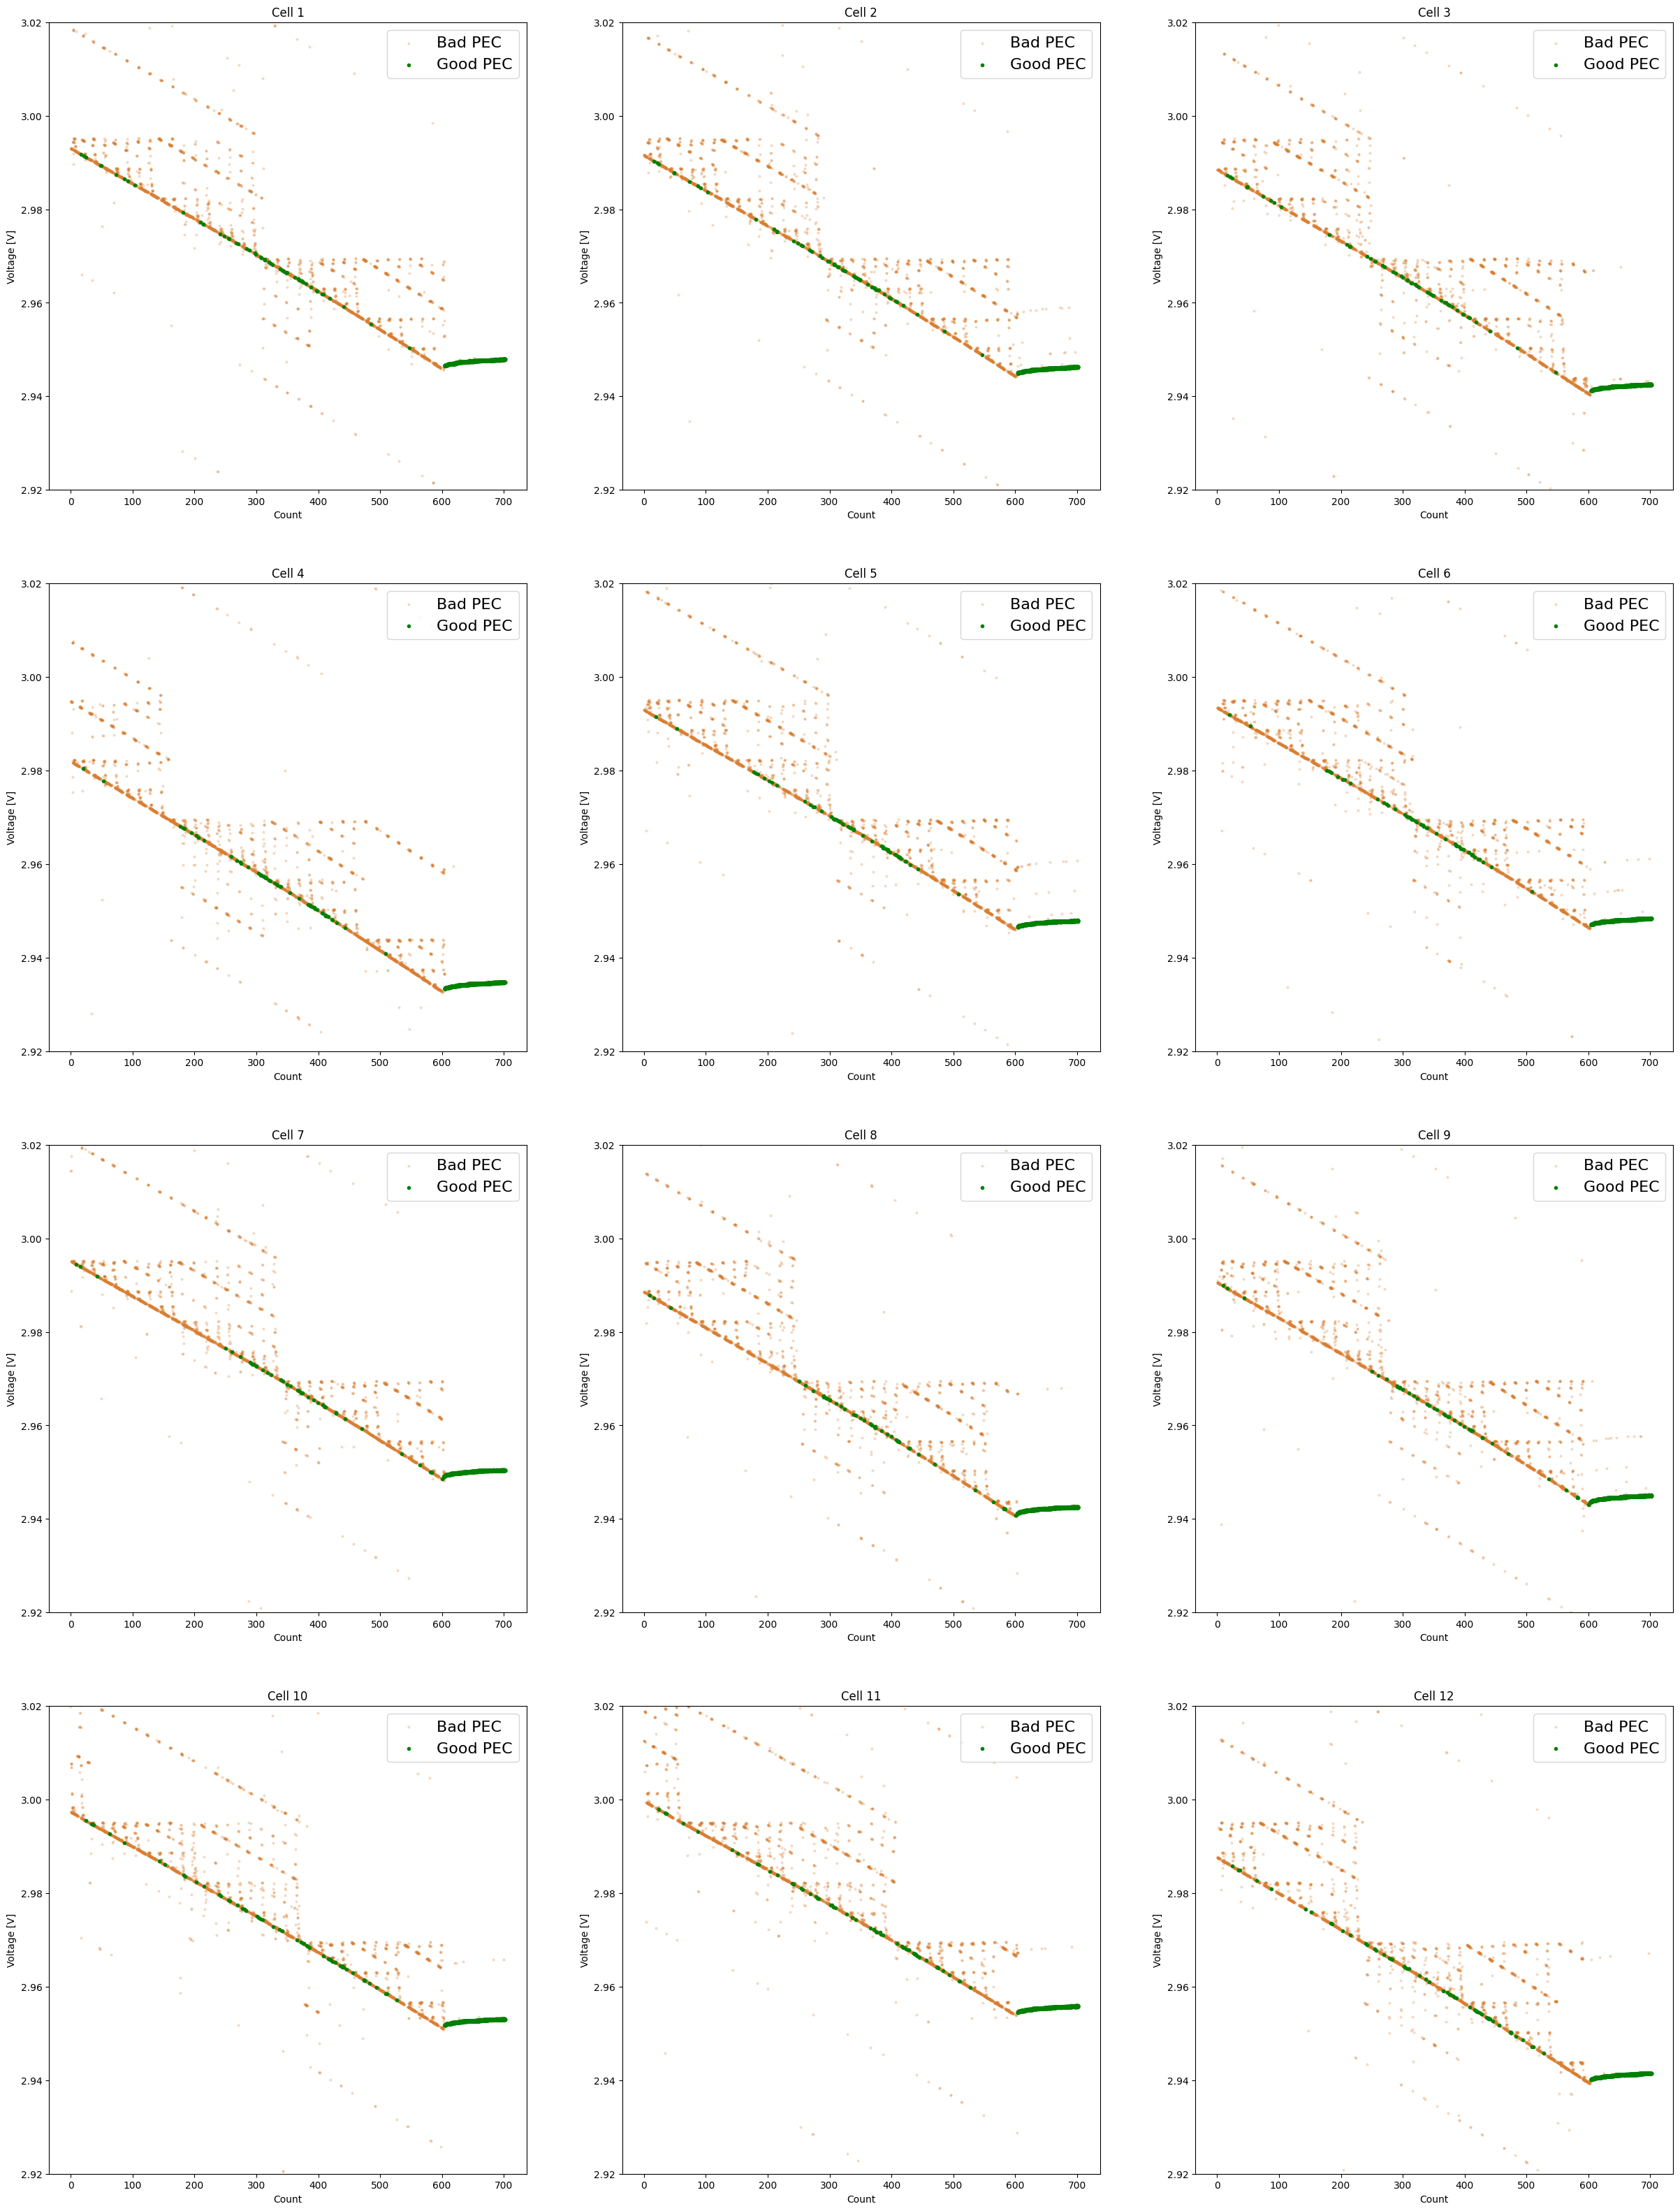

In [13]:
## Good PEC only plots

start = 1
end = 12

zoom = True

t = np.arange(0, cell_v.shape[0], 1)/10

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))


for i in range(start-1, end):
    good_v = []
    good_t = []
    bad_v = []
    bad_t = []

    for j in range (0, cell_v.shape[0]):
        if (pec_ok[4*j + int(i / 3)]):
            good_v.append(cell_v[j,i])
            good_t.append(t[j])
        else:
            bad_v.append(cell_v[j,i])
            bad_t.append(t[j])

    plot = axs[int(i/3),int(i%3)]
    plot.scatter(bad_t, bad_v, s=8, color='#D97E30', label='Bad PEC', alpha=0.3, linewidths=0)
    plot.scatter(good_t, good_v, s=9, color='g', label='Good PEC')
    plot.legend(loc="upper right", prop={'size': 16})

    if zoom:
        # plot.set_ylim([2.00, 3.30])
        plot.set_ylim([2.92, 3.02])
    plot.set_xlabel("Count")
    plot.set_ylabel("Voltage [V]")
    name = "Cell " + str(i+1)
    plot.set_title(name)

Text(0.5, 0, 'Time [s]')

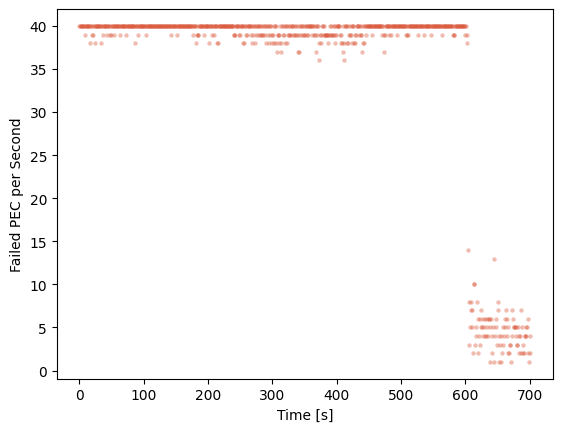

In [14]:
## PEC Fails per second
pecps = []
count = 0

i = 0
while i < len(pec_ok):
    for j in range(0, 40):
        if not pec_ok[i]:
            count += 1
        i += 1
    
    pecps.append(count)
    count = 0

n = np.arange(0, len(pecps), 1)

fig, axs = plt.subplots()
plt.scatter(n, pecps, s=10, color='#DB583B', alpha=0.4, linewidths=0)
plt.ylabel("Failed PEC per Second")
plt.xlabel("Time [s]")

In [15]:
## Cell V with KDE
t = np.arange(0, cell_v.shape[0], 1)/10

# Cells # (1-12) to plot
start = 1
end = 12

enable = False
if enable:
    for i in range(start-1, end):
        x_label = "Time [s]"
        y_label = "Cell " + str(i+1) + " Voltage"
        cell_df = pd.DataFrame({x_label: t, y_label: cell_v[:,i]})
        g = sns.JointGrid(data = cell_df, x = x_label, y = y_label)
        sns.scatterplot(x=t[:], y=cell_v[:,i], s=20, alpha=.3, ax=g.ax_joint)
        sns.histplot(y=cell_v[:,i], ax=g.ax_marg_y, kde=True, linewidth=0, color=[240/255,105/255,0/255])
        g.refline(y=2.99)

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


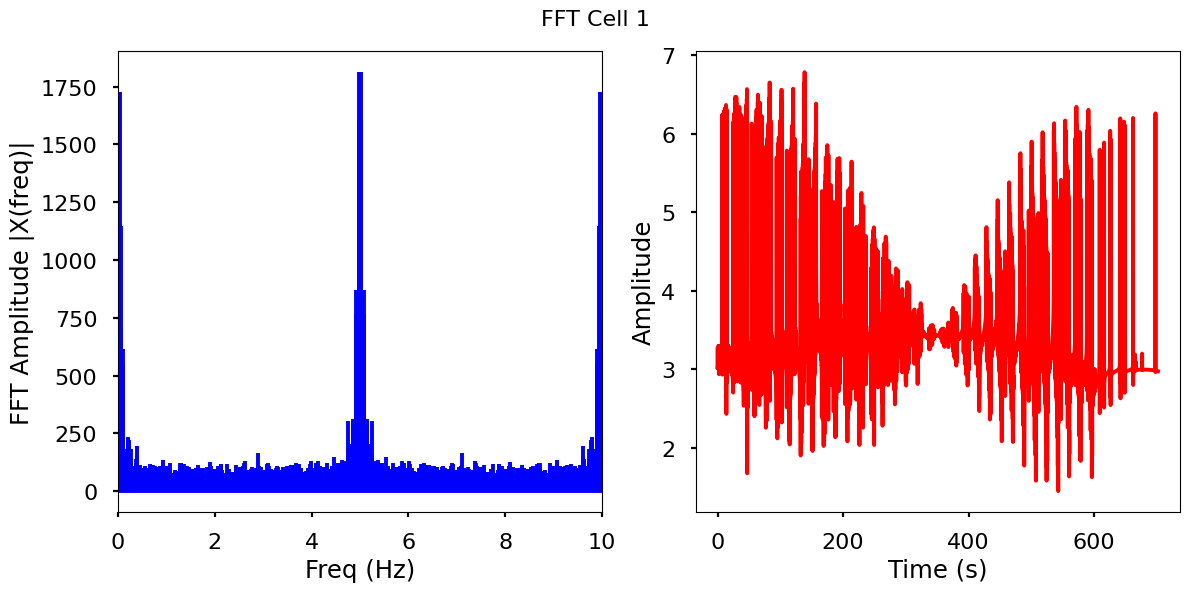

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


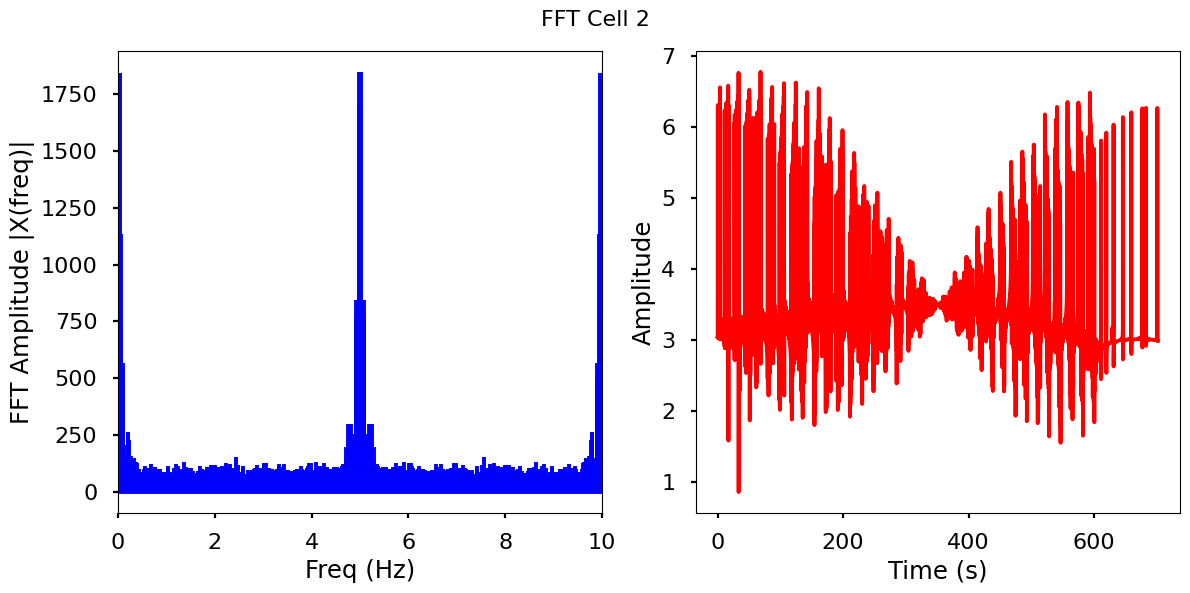

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


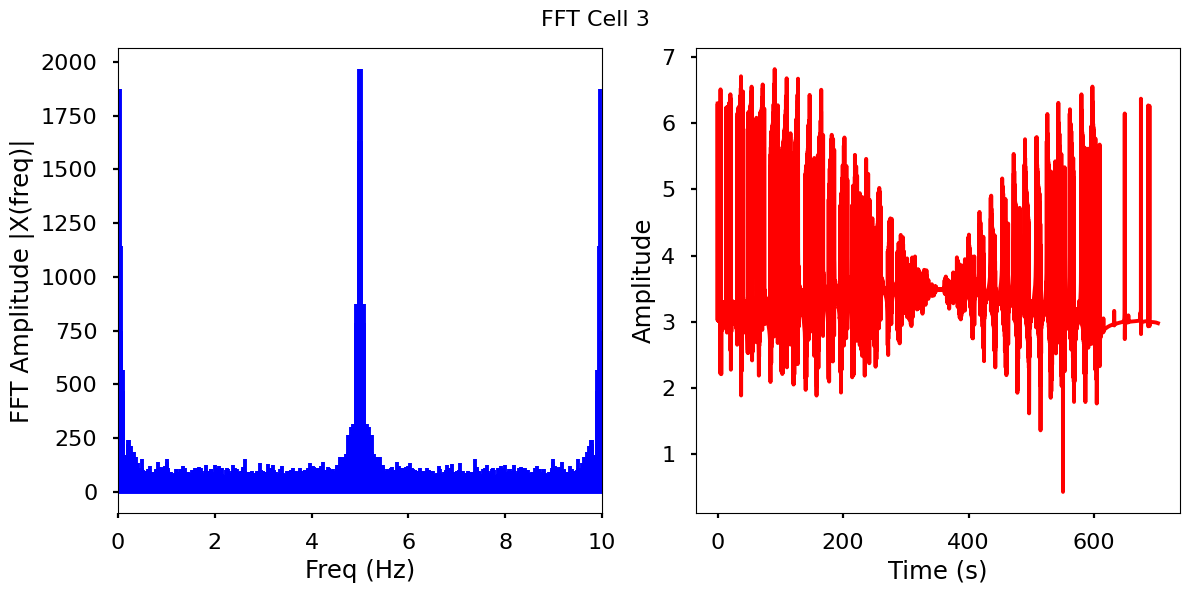

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


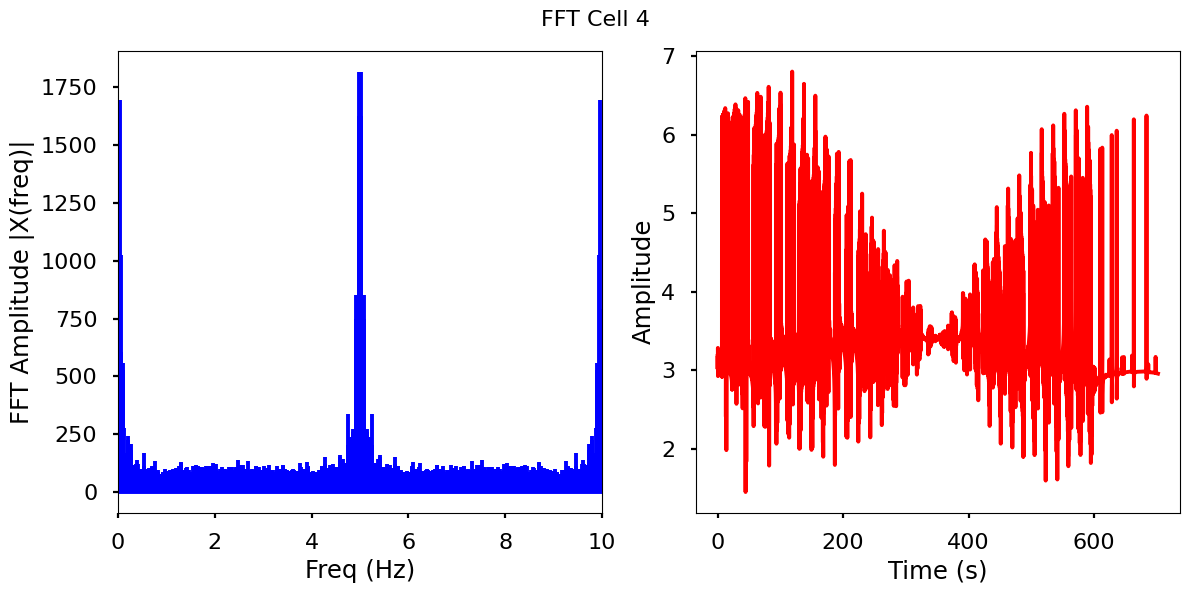

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


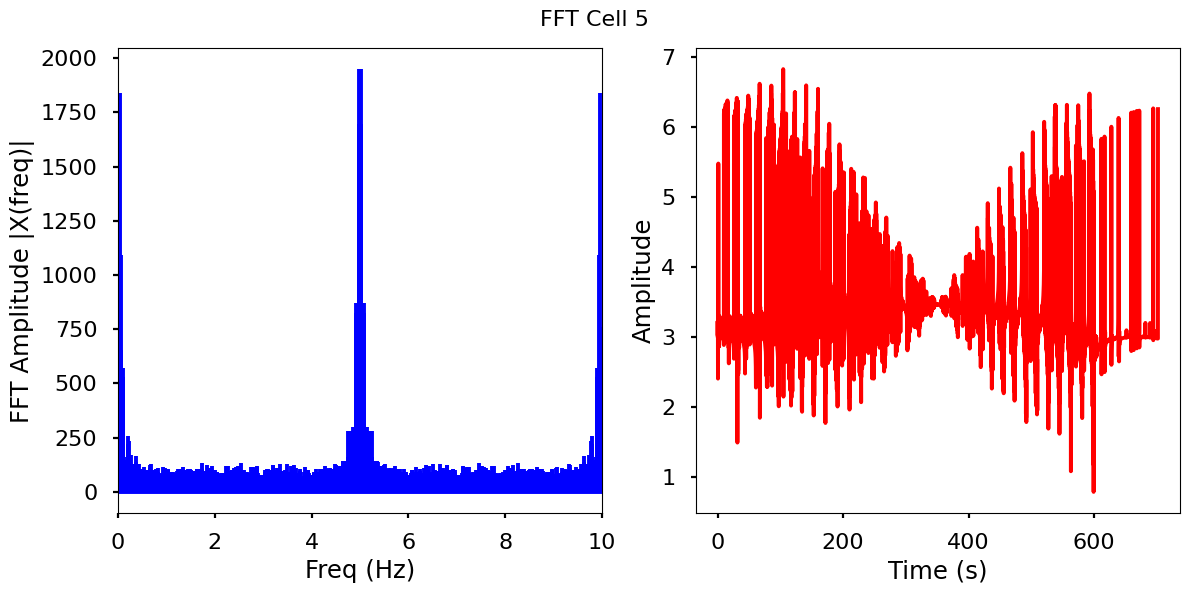

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


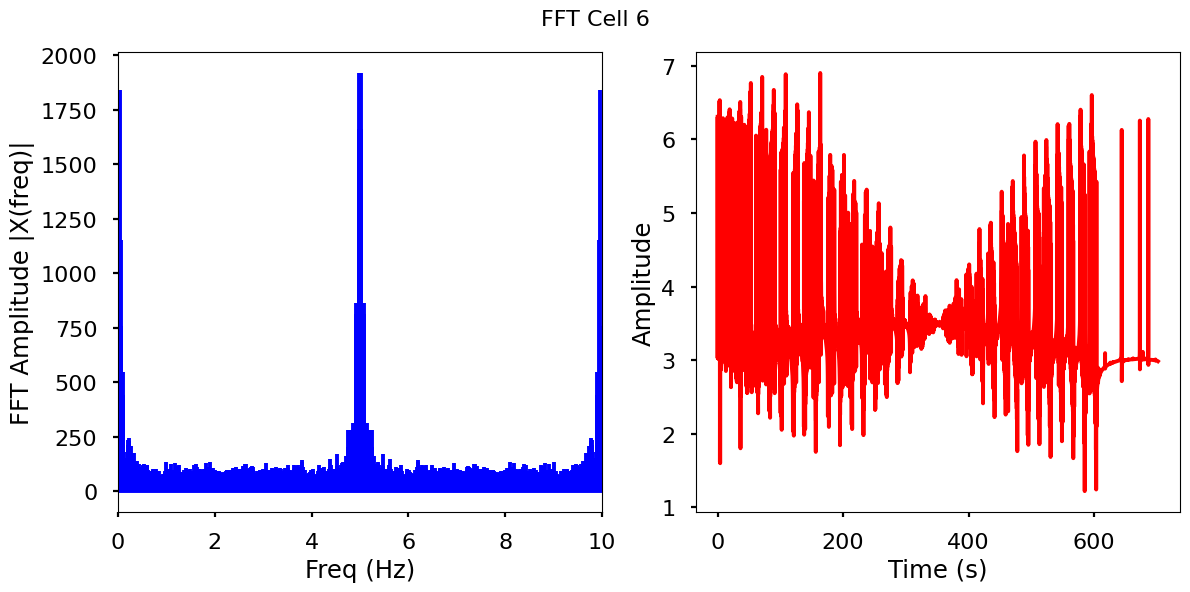

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


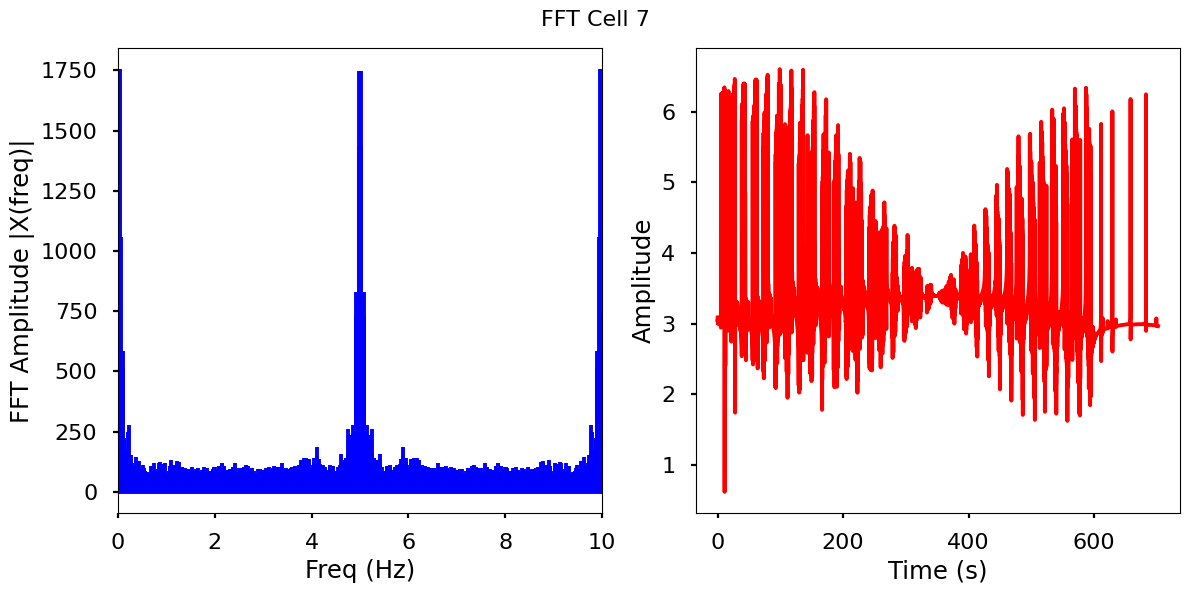

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


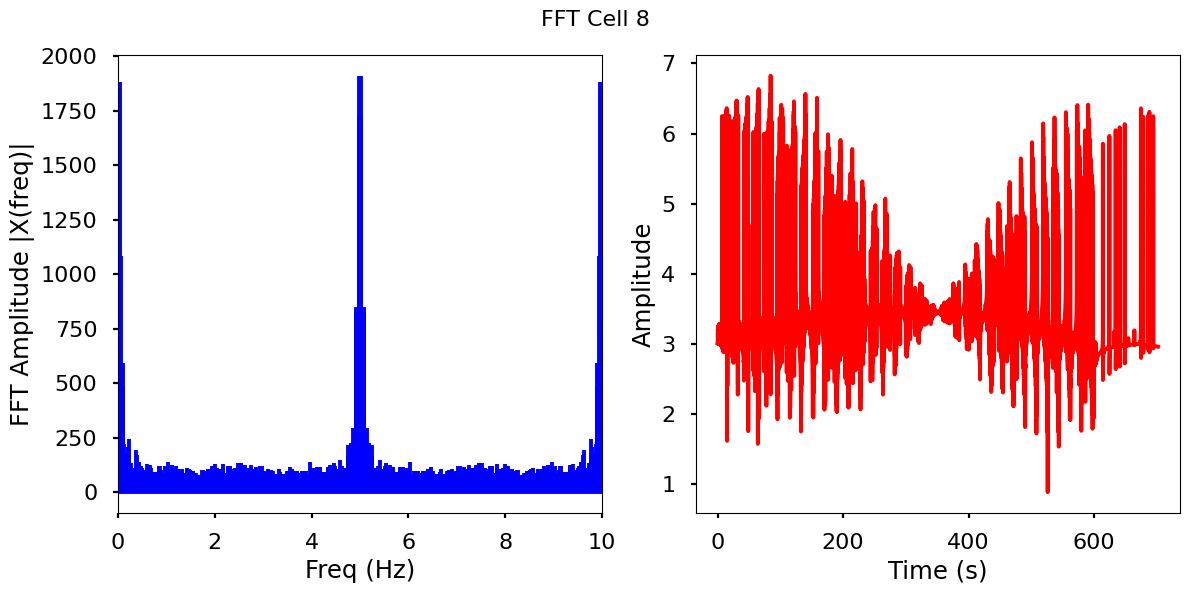

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


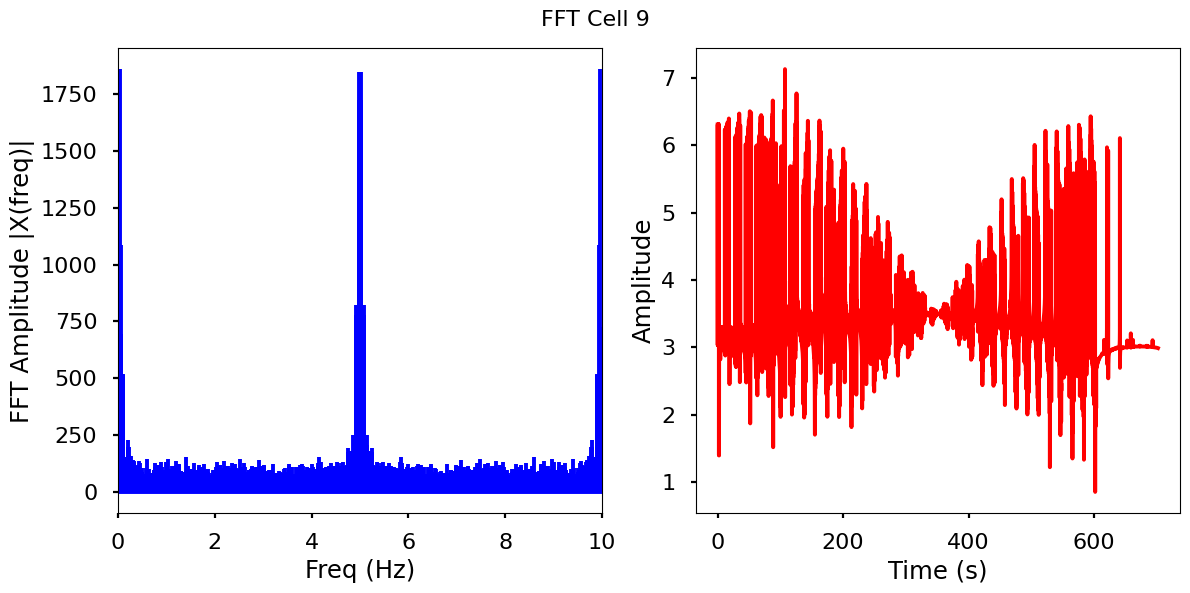

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


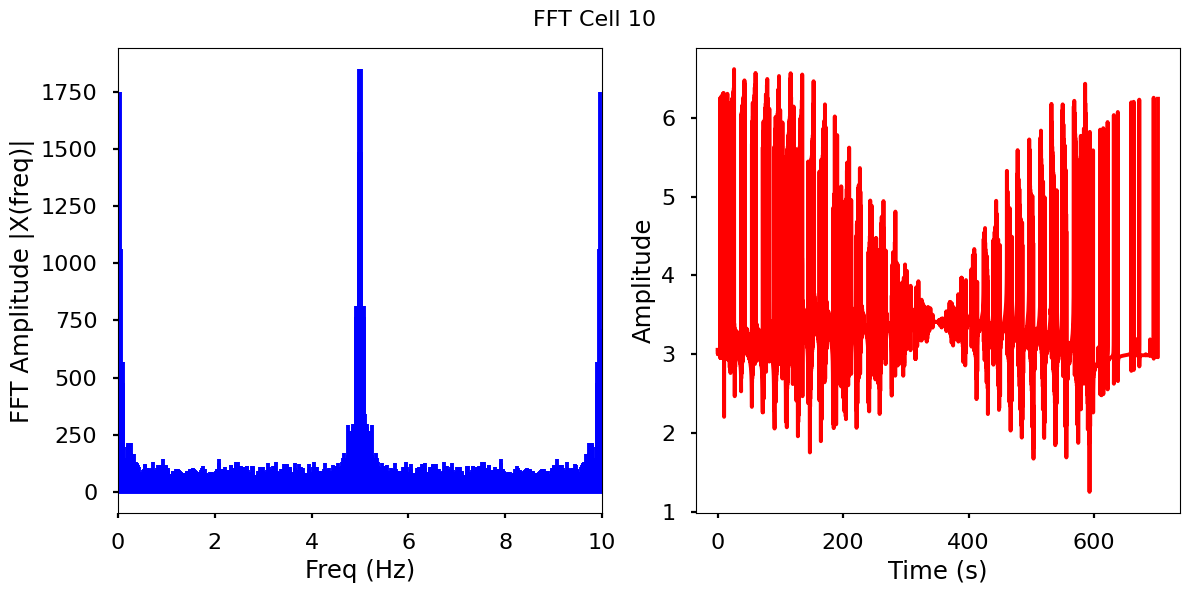

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


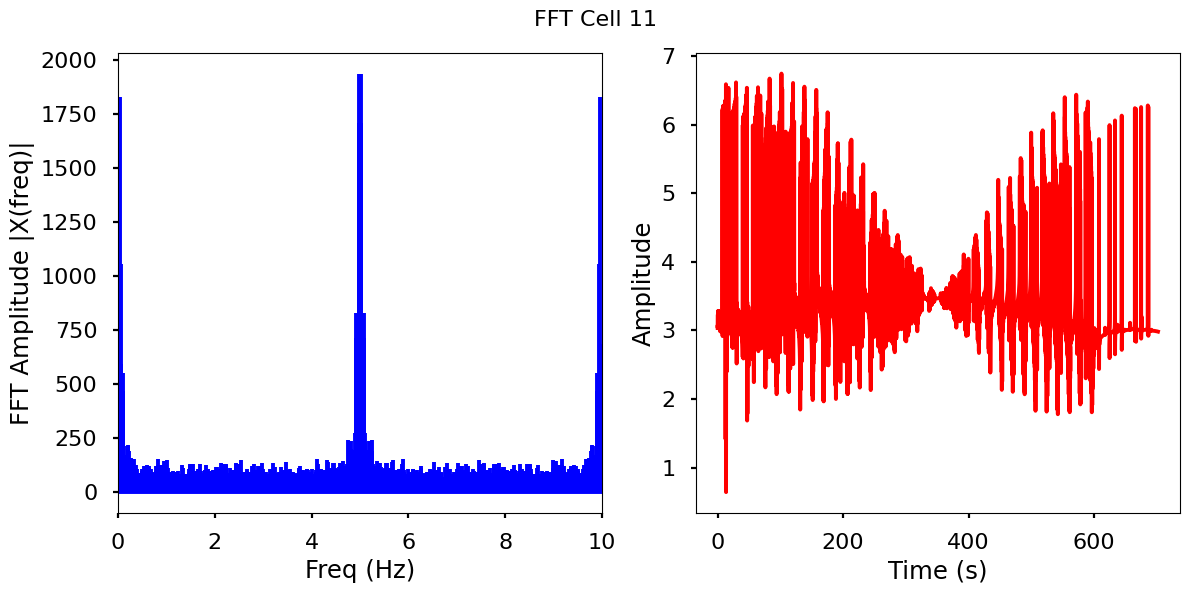

c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\env\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


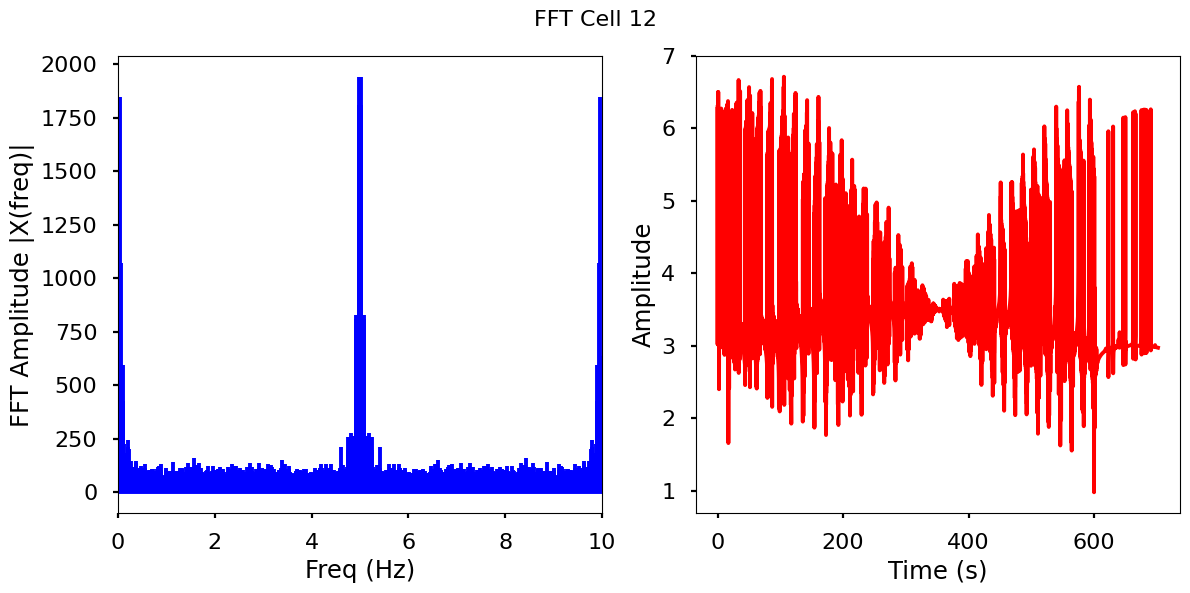

In [16]:
## Frequencies

# Data sample rate
sr = 10 # Hz

# Cells # (1-12) to plot
start = 1
end = 12

for i in range(start-1, end):
    X = np.fft.fft(cell_v[:,i])
    N = len(X)
    n = np.arange(N)
    T = N/sr
    freq = n/T
    t = np.arange(0, T, 1/sr)

    plt.style.use('seaborn-v0_8-poster')
    %matplotlib inline
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    name = "FFT Cell " + str(i+1)
    plt.suptitle(name, fontsize=16)

    plt.stem(freq[3:-1], np.abs(X[3:-1]), 'b', \
            markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(0, 10)

    plt.subplot(122)
    plt.plot(t[0:-1], np.fft.ifft(X[0:-1]), 'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
